In [1]:
!pip install cartopy

In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline

In [3]:
drive.mount('/content/gdrive')

# Replace by the real path to file
files_path = [f'/content/gdrive/MyDrive/ENSC/3A/Deep Learning/data/era5/features_{i}.csv' for i in range(5)]

def load_and_preprocess_data(files_path):
    """
    Load the dataset from the given folder path and perform preprocessing steps.
    """
    # Initialize an empty DataFrame
    df = pd.DataFrame()

    if isinstance(files_path, list):
        # Concatenate all CSV files in the list
        for file_path in files_path:
            temp_df = pd.read_csv(file_path)
            df = pd.concat([df, temp_df], axis=0)

    df = df.drop(['g', 'sst'], axis=1)
    df = df.dropna()
    df.sort_values(by=['time','latitude','longitude'])

    for col in df.select_dtypes(include='float64').columns:
        df[col] = df[col].astype('float32', copy=False)

    return df

df = load_and_preprocess_data(files_path)
df.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3594276 entries, 0 to 718854
Data columns (total 11 columns):
 #   Column     Dtype  
---  ------     -----  
 0   time       object 
 1   latitude   float32
 2   longitude  float32
 3   10u        float32
 4   10v        float32
 5   100u       float32
 6   100v       float32
 7   msl        float32
 8   swvl1      float32
 9   geo500     float32
 10  2t         float32
dtypes: float32(10), object(1)
memory usage: 192.0+ MB


In [4]:
df

,time,latitude,longitude,10u,10v,100u,100v,msl,swvl1,geo500,2t
0,1940-01-01 00:00:00,38.0,125.00,0.419250,-6.994049,0.539322,-7.767197,102701.6875,0.000002,54024.832031,-2.504486
1,1940-01-01 00:00:00,38.0,125.25,0.267883,-5.567291,0.401627,-6.972275,102700.4375,0.182467,54007.832031,-4.463470
2,1940-01-01 00:00:00,38.0,125.50,0.320618,-4.622955,0.482681,-6.185165,102706.6875,0.229876,53989.582031,-6.065033
3,1940-01-01 00:00:00,38.0,125.75,0.107727,-4.240143,0.275650,-5.673447,102706.1875,0.208132,53971.082031,-6.861908
4,1940-01-01 00:00:00,38.0,126.00,0.156555,-3.693268,0.290298,-5.080673,102703.6875,0.293429,53953.582031,-7.449799
...,...,...,...,...,...,...,...,...,...,...,...
718850,2023-11-19 12:00:00,34.0,129.00,10.564636,-3.080109,11.930634,-3.466751,101845.8750,0.000005,55508.691406,16.389801
718851,2023-11-19 12:00:00,34.0,129.25,10.969910,-2.972687,12.307587,-3.304642,101832.6250,0.000005,55488.191406,16.299957
718852,2023-11-19 12:00:00,34.0,129.50,10.767761,-2.702179,12.258759,-3.010696,101818.6250,0.000005,55467.941406,16.333160
718853,2023-11-19 12:00:00,34.0,129.75,11.442566,-2.366241,12.838837,-2.653275,101801.6250,0.000005,55448.691406,16.514801


In [5]:
df_av_month = df.copy()
df_av_month['time'] = pd.to_datetime(df_av_month['time']).dt.to_period('M')
df_av_month = df_av_month.groupby(['time','latitude','longitude']).mean().reset_index().sort_values(by=['time', 'latitude', 'longitude'])
df_av_month

,time,latitude,longitude,10u,10v,100u,100v,msl,swvl1,geo500,2t
0,1940-01,34.0,125.00,3.109276,-6.966927,3.416429,-7.617950,102041.054688,0.000002,53475.031250,3.971347
1,1940-01,34.0,125.25,3.254979,-7.084505,3.583031,-7.763556,102020.429688,0.000002,53457.156250,3.998691
2,1940-01,34.0,125.50,3.445702,-7.237923,3.785765,-7.901642,101997.531250,0.000002,53440.457031,4.070566
3,1940-01,34.0,125.75,3.635838,-7.284895,4.025414,-8.021955,101975.203125,0.000002,53422.656250,4.018027
4,1940-01,34.0,126.00,3.873924,-7.324837,4.305491,-8.090411,101950.679688,0.000002,53405.382812,4.145175
...,...,...,...,...,...,...,...,...,...,...,...
359494,2023-11,38.0,129.00,6.074238,0.989002,7.530390,1.212111,101801.609375,0.000004,55013.378906,11.436935
359495,2023-11,38.0,129.25,7.215717,-0.111340,8.244989,-0.191332,101796.859375,0.000004,54990.316406,12.330246
359496,2023-11,38.0,129.50,7.551777,-0.940319,8.650873,-1.085985,101783.203125,0.000004,54970.910156,12.700607
359497,2023-11,38.0,129.75,7.590595,-1.631847,8.827387,-1.780443,101771.328125,0.000004,54954.503906,12.885666


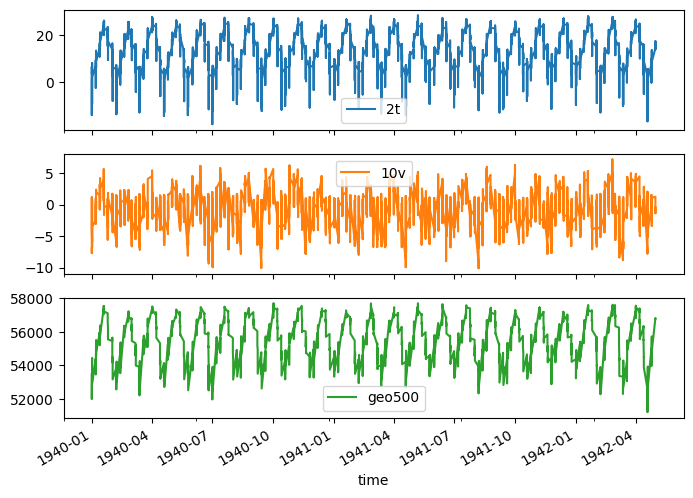

In [6]:
date_time = pd.to_datetime(df['time'], format='%Y.%m')

plot_cols = ['2t', '10v', 'geo500']

plot_features = df_av_month[plot_cols][:100000]
plot_features.index = date_time[:100000]
_ = plot_features.plot(subplots=True)

In [7]:
# Extract relevant columns
lat = df_av_month['latitude'].unique()
lon = df_av_month['longitude'].unique()
features = ['10u', '10v','100u','100v','msl','swvl1','geo500','2t']
# features = ['2t']
timesteps = df_av_month['time'].unique()

# Create an empty 4D array
shape = (len(timesteps), len(lat), len(lon), len(features))
data_array = np.zeros(shape)

# Fill the array with data from the DataFrame
for i, lat_val in enumerate(lat):
  for j, lon_val in enumerate(lon):
    for k, feature in enumerate(features):
      subset = df_av_month[(df_av_month['longitude'] == lon_val) & (df_av_month['latitude'] == lat_val)]

      # Ensure that the subset has the same length as 'timesteps'
      assert len(subset) == len(timesteps), f"Warning: Length of subset ({len(subset)}) does not match timesteps ({len(timesteps)}) for lon={lon_val}, lat={lat_val}"

      data_array[:, i, j, k] = subset[feature].values

# Now, data_array is a 4D NumPy array with the shape (time, features, lat, lon)
f"Shape dataset : (Timesteps: {data_array.shape[0]}, Latitude: {data_array.shape[1]}, Longitude: {data_array.shape[2]}, Features: {data_array.shape[3]})"

'Shape dataset : (Timesteps: 1007, Latitude: 17, Longitude: 21, Features: 8)'

In [8]:
def split_data(data):
    """
    Function to split time series data into train, val and test set.
    Respectively : 70% / 20% / 10%
    """
    num_timesteps=data.shape[0]

    train_array = data[0:int(num_timesteps*0.7), :, :, :]
    val_array = data[int(num_timesteps*0.7):int(num_timesteps*0.9), :, :, :]
    test_array = data[int(num_timesteps*0.9):, :, :, :]

    return train_array, val_array, test_array

In [9]:
def scale(train_array, val_array, test_array):
    """
    Function to scale the entire dataset in place using the mean and standard deviation of the training data only.
    """
    # Example shapes
    train_shape = train_array.shape
    val_shape = val_array.shape
    test_shape = test_array.shape

    # Reshape to 2D
    train_reshaped = train_array.reshape(-1, train_shape[-1])
    val_reshaped = val_array.reshape(-1, val_shape[-1])
    test_reshaped = test_array.reshape(-1, test_shape[-1])

    # Initialize and fit StandardScaler on the training data
    std_scaler = StandardScaler()
    train_scaled = std_scaler.fit_transform(train_reshaped)

    # Transform the validation and test data
    val_scaled = std_scaler.transform(val_reshaped)
    test_scaled = std_scaler.transform(test_reshaped)

    # Reshape back to original 4D shape
    train_array = train_scaled.reshape(train_shape)
    val_array = val_scaled.reshape(val_shape)
    test_array = test_scaled.reshape(test_shape)

    return train_array, val_array, test_array, std_scaler

In [10]:
num_features = data_array.shape[-1]

train_array, val_array, test_array = split_data(data_array)
print(f"Train size: {train_array.shape}")
print(f"Val size: {val_array.shape}")
print(f"Test size: {test_array.shape}")
print(f"Number of features: {num_features}")

scaled_train_array, scaled_val_array, scaled_test_array, std_scaler = scale(train_array, val_array, test_array)

Train size: (704, 17, 21, 8)
Val size: (202, 17, 21, 8)
Test size: (101, 17, 21, 8)
Number of features: 8


In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_array=scaled_train_array, val_array=scaled_val_array, test_array=scaled_test_array,
               label_columns=None):
    # Store the raw data.
    self.train_array = train_array
    self.val_array = val_array
    self.test_array = test_array

    # Work out the label column indices.
    self.label_columns = label_columns
    self.column_indices = {name: i for i, name in
                           enumerate(features)}
    self.label_column_indices = {name: i for i, name in
                           enumerate(label_columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    # Meant to be used for extracting input samples from window
    self.input_slice = slice(0, input_width)
    # np.arange(5), creates an array from 0 to 4 (start=0, stop=5, step=1)
    # Generate input indices of a given window
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    # Meant to be used for extracting target samples from window
    self.labels_slice = slice(self.label_start, None)
    # Generate output indices of a given window
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

In [12]:
def unscale(self, scaled_data, std_scaler=std_scaler):
    """
    Function to inverse scaling of data in place by using the mean and standard deviation of the training data only.
    """
    original_shape = scaled_data.shape

    # Reshape scaled data to 2D
    scaled_reshaped = scaled_data.reshape(-1, original_shape[-1])

    if original_shape[-1] == 1:  # unscale label data
        unscaled_data = scaled_data * np.sqrt(std_scaler.var_[features.index('2t')]) + std_scaler.mean_[features.index('2t')]
    else:
        # Apply inverse_transform
        unscaled_data = std_scaler.inverse_transform(scaled_reshaped)

    # Reshape back to the original shape
    unscaled_data = unscaled_data.reshape(original_shape)

    return unscaled_data

WindowGenerator.unscale = unscale

In [94]:
# TODO : Find a city given its coordinates in an array of shape (lat, lon)
def plot(self, unscale_data = False, model=None, lon=0, lat=0, plot_col='2t', max_subplots=3):
  inputs, labels = self.example

  # Unscale data if needed for visualization
  if unscale_data:
    inputs = self.unscale(inputs.numpy())
    labels = self.unscale(labels.numpy())

  plt.figure(figsize=(12, 4))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, lat, lon, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    plt.scatter(self.label_indices, labels[n, :, lat, lon, :],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model.predict(inputs)

      if unscale_data:
          predictions = self.unscale(predictions)

      assert predictions.shape == labels.shape, f"Actual prediction shape: {predictions.shape}, Expected label shape: {labels.shape}"
      plt.scatter(self.label_indices, predictions[n, :, lat, lon, :],
                marker='X', edgecolors='k', label='Predictions',
                c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [86]:
inputs, labels = window.example
predictions = lstm_model.predict(inputs)
predictions_test = window.unscale(predictions)

# Check if the arrays are element-wise close within a tolerance
assert np.allclose(predictions_test[0,:,:,:,:], predictions_test[2,:,:,:,:], atol=1e-2)

1/1 [==============================] - 0s 326ms/step


AssertionError: ignored

In [14]:
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader

batch_size = 12

# Create a custom TensorFlow Dataset
class TimeSeriesDataset(tf.keras.utils.Sequence):
    def __init__(self, data):
        self.data = data
        self.window = window

    def __len__(self):
        return self.data.shape[0] - self.window.total_window_size + 1

    def __getitem__(self, idx):
        window_data = self.data[idx:idx+self.window.total_window_size, :, :, :]

        # Perform your split_window operation here
        inputs = window_data[self.window.input_slice, :, :, :]
        labels = window_data[self.window.labels_slice, :, :, :]

        if self.window.label_columns is not None:
            labels = np.stack([labels[:, :, :, self.window.column_indices[name]] for name in self.window.label_columns], axis=3)

        return inputs, labels

def make_dataset(self, data):
  # Create an instance of the custom dataset
  time_series_dataset = TimeSeriesDataset(data)

  # Use TensorFlow Dataset for batching
  dataset = tf.data.Dataset.from_generator(lambda: time_series_dataset,
                                            output_signature=(tf.TensorSpec(shape=time_series_dataset[0][0].shape, dtype=tf.float32),
                                                              tf.TensorSpec(shape=time_series_dataset[0][1].shape, dtype=tf.float32)))

  # Shuffle the dataset
  dataset = dataset.shuffle(buffer_size=len(time_series_dataset))

  # Batch the dataset
  dataset = dataset.batch(batch_size)

  # Take a batch from the dataloader
  batch_iterator = iter(dataset)
  batch = next(batch_iterator)

  assert batch[0].shape == (batch_size, self.input_width, lat.shape[0], lon.shape[0], len(features)), \
      f"Actual input shape: {batch[0].shape}, Expected input shape: {(batch_size, self.input_width, lat.shape[0], lon.shape[0], len(features))}"

  if self.label_columns is not None:
      assert batch[1].shape == (batch_size, self.label_width, lat.shape[0], lon.shape[0], len(self.label_columns)), \
          f"Actual label shape: {batch[1].shape}, Expected label shape: {(batch_size, self.label_width, lat.shape[0], lon.shape[0], len(self.label_columns))}"
  else:
      assert batch[1].shape == (batch_size, self.label_width, lat.shape[0], lon.shape[0], len(label_columns)), \
          f"Actual label shape: {batch[1].shape}, Expected label shape: {(batch_size, self.label_width, lat.shape[0], lon.shape[0], len(label_columns))}"


  return dataset

def make_test_dataset(self, data):
  # Create an instance of the custom dataset
  time_series_dataset = TimeSeriesDataset(data)

  # Use TensorFlow Dataset for batching
  dataset = tf.data.Dataset.from_generator(lambda: time_series_dataset,
                                            output_signature=(tf.TensorSpec(shape=time_series_dataset[0][0].shape, dtype=tf.float32),
                                                              tf.TensorSpec(shape=time_series_dataset[0][1].shape, dtype=tf.float32)))

  dataset = dataset.batch(1)

  return dataset

WindowGenerator.make_dataset = make_dataset
WindowGenerator.make_test_dataset = make_test_dataset

In [96]:
# The @property decorator allows you to define a method that can be accessed
# like an attribute, but it will be computed dynamically when it is accessed

@property
def train(self):
  return self.make_dataset(self.train_array)

@property
def val(self):
  return self.make_dataset(self.val_array)

@property
def test(self):
  return self.make_test_dataset(self.test_array)

@property
def example(self):
  """
  Get and cache an example batch of `inputs, labels` for plotting.
  The method uses a caching mechanism to avoid recomputing the example
  batch every time it is accessed
  """
  # Check if self._example exist
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.test` dataset
    result = next(iter(self.test))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

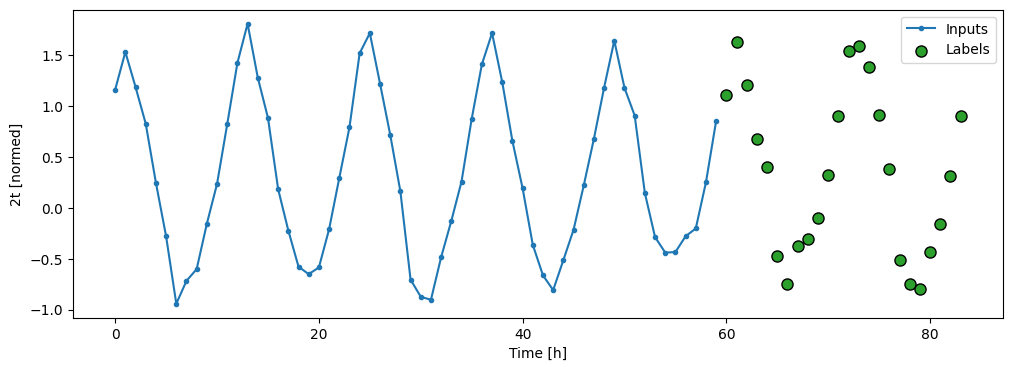

In [97]:
# We have one sample per month between 1940-01 and 2023-11

max_window_size = int(test_array.shape[0]/12)
years_to_look = int(2/3 * max_window_size)
years_to_predict = int(1/3 * max_window_size)

OUT_STEPS = years_to_predict * 12
window = WindowGenerator(input_width=years_to_look * 12,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['2t'])

window.plot()
window

In [17]:
test_timesteps = timesteps[int(len(timesteps)*0.9):]
print("Interval of our testing dataset")
print(f"Min time : {test_timesteps.min()}")
print(f"Max time : {test_timesteps.max()}")
print(f"Total number of months : {len(test_timesteps)}")

Interval of our testing dataset
Min time : 2015-07
Max time : 2023-11
Total number of months : 101


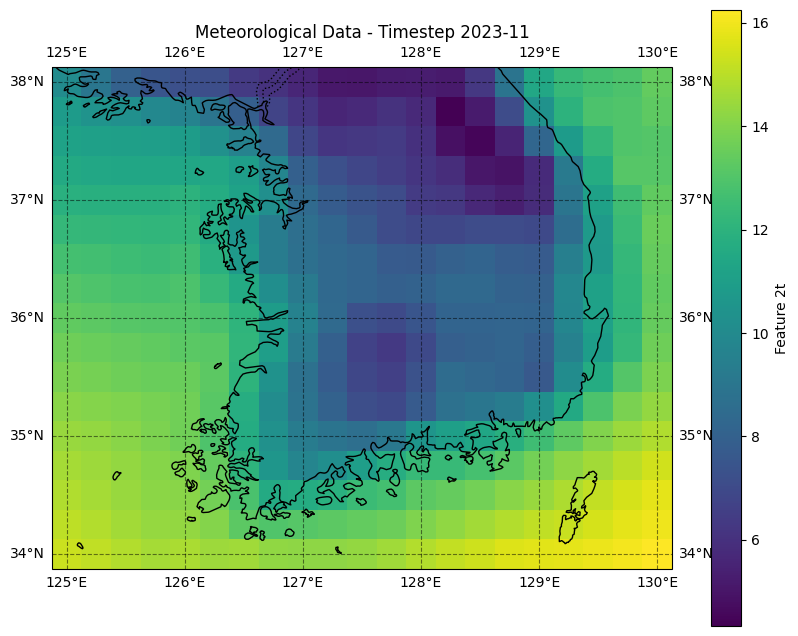

In [18]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np

def plot_meteorological_data(data, lat = lat, lon = lon, feature_index = features.index('2t'), feature_name='2t', timesteps = test_timesteps, date = str(test_timesteps.min()), title="Meteorological Data"):
    """
    Plot meteorological data on a map using Cartopy.
    """
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))

    timestep = np.where(timesteps == date)[0][0]

    # Reshape data for pcolormesh
    X, Y = np.meshgrid(lon, lat)
    C = data[timestep, :, :, feature_index]

    assert X.shape == C.shape and Y.shape == C.shape

    # Plot the meteorological data
    im = ax.pcolormesh(X, Y, C, cmap='viridis', transform=ccrs.PlateCarree(), shading='auto')

    # Add coastlines and country borders
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

    # Add gridlines
    ax.gridlines(draw_labels=True, linestyle='--', color='black', alpha=0.5)

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, label=f"Feature {feature_name}")

    # Set plot title
    plt.title(f"{title} - Timestep {timesteps[timestep]}")

    # Show the plot
    plt.show()

# Example usage:
plot_meteorological_data(test_array, date = '2023-11')

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, MaxPooling2D, LSTM, Reshape, Activation, Conv2D, Input, TimeDistributed

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print('Training on GPU')
else:
    print('No GPU available, training on CPU')

input_shape = (window.input_width, lat.shape[0], lon.shape[0], len(features))
patience = 2

# Use MirroredStrategy for distributed training on GPUs
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    lstm_model = tf.keras.Sequential([
        Input(shape=input_shape),
        TimeDistributed(Conv2D(filters=32, kernel_size=3, padding='same')),
        TimeDistributed(Activation('relu')),
        TimeDistributed(MaxPooling2D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(units=32, return_sequences=False, go_backwards=True),
        Dense(units=(OUT_STEPS * len(lat) * len(lon) * len(window.label_columns))),
        Reshape([OUT_STEPS, len(lat), len(lon), len(window.label_columns)])
  ])

    initial_learning_rate = 0.005
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
    )

    # Use Adam optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    # Create and compile the model inside the strategy scope
    lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])



lstm_model.build(input_shape=(None, window.input_width, num_features))
lstm_model.summary()

No GPU available, training on CPU
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 60, 17, 21, 32)    2336      
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 60, 17, 21, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 60, 8, 10, 32)     0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 60, 2560)          0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)      

In [36]:
MAX_EPOCH = 50
lstm_model.fit(window.train,
               epochs=MAX_EPOCH,
               validation_data=window.val,
               callbacks=[early_stopping])

Epoch 1/50
52/52 [==============================] - 17s 303ms/step - loss: 0.0273 - mean_absolute_error: 0.1256 - val_loss: 0.0353 - val_mean_absolute_error: 0.1461
Epoch 2/50
52/52 [==============================] - 18s 338ms/step - loss: 0.0259 - mean_absolute_error: 0.1222 - val_loss: 0.0368 - val_mean_absolute_error: 0.1490
Epoch 3/50
52/52 [==============================] - 17s 320ms/step - loss: 0.0260 - mean_absolute_error: 0.1224 - val_loss: 0.0357 - val_mean_absolute_error: 0.1466


In [102]:
# Generate output

# Simulate batch
expanded_test_array = np.expand_dims(test_array, axis=0)

print(f"Window size: {window.total_window_size}")
print(f"Window input size: {window.input_width} => {int(window.input_width/12)} years as input data to predict")
print(f"Window output size: {window.label_width} => prediction for the next {int(window.label_width/12)} years")

print(f"Test size: {expanded_test_array.shape[1]}")
input = expanded_test_array[:,window.input_slice,:,:,:]

outputs = window.unscale(lstm_model.predict(input))

prediction_timesteps = test_timesteps[window.input_width:window.total_window_size]
print("Interval of our prediction dataset")
print(f"Min time : {prediction_timesteps.min()}")
print(f"Max time : {prediction_timesteps.max()}")
print(f"Total number of months : {len(prediction_timesteps)}")

date='2021-07'
# Prediction temperation at date need to be predicted by the model
assert date in prediction_timesteps

Window size: 84
Window input size: 60 => 5 years as input data to predict
Window output size: 24 => prediction for the next 2 years
Test size: 101
1/1 [==============================] - 0s 153ms/step
Interval of our prediction dataset
Min time : 2020-07
Max time : 2022-06
Total number of months : 24


1/1 [==============================] - 0s 166ms/step


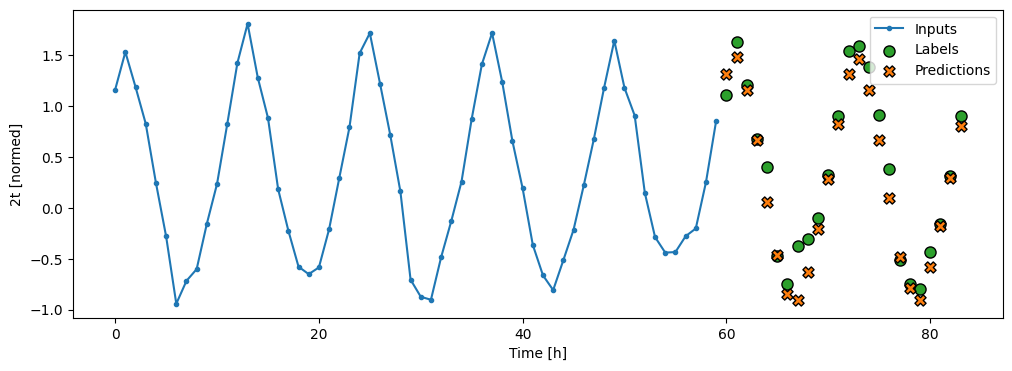

In [103]:
window.plot(unscale_data = False, model = lstm_model)

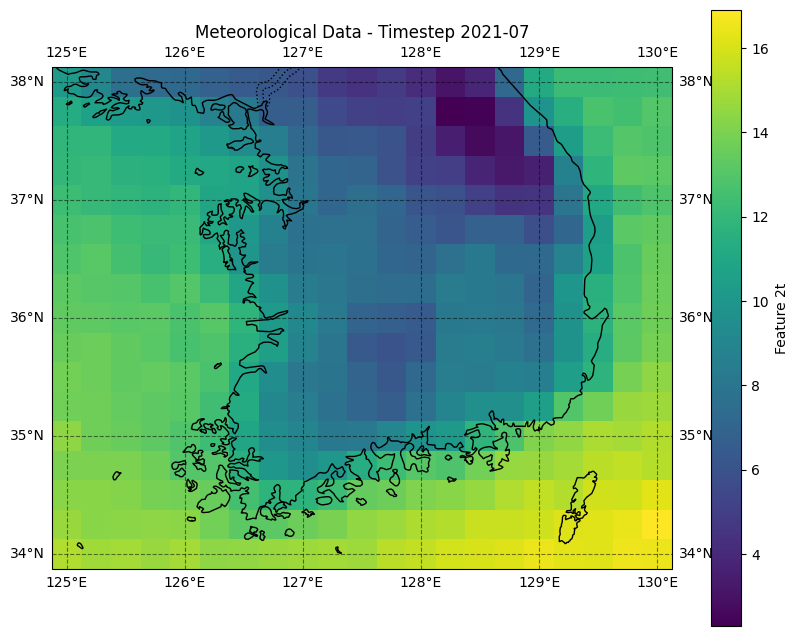

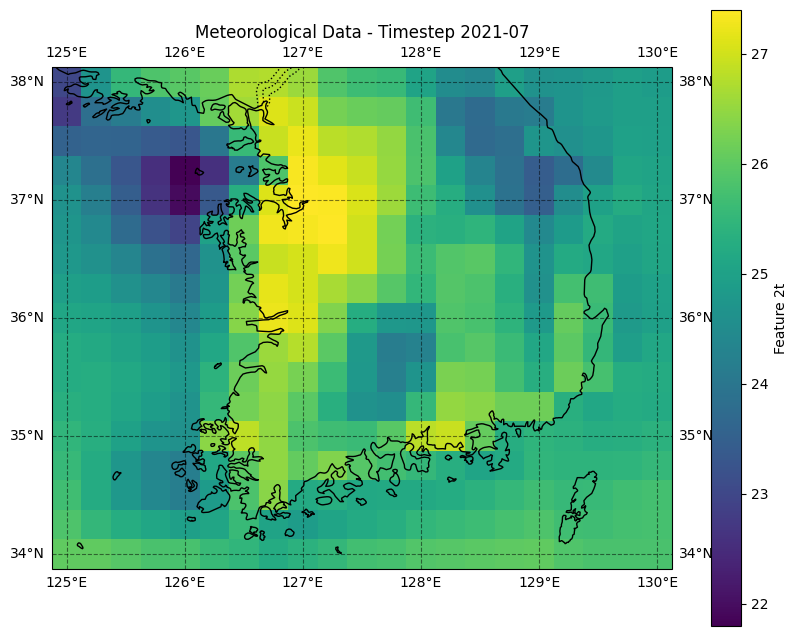

In [104]:
plot_meteorological_data(outputs[0], feature_index = window.label_columns.index('2t'), timesteps = prediction_timesteps, date=date)
plot_meteorological_data(test_array, date = date)

In [ ]:
batch = next(iter(window.test))

input = batch[0]

outputs = window.unscale(lstm_model.predict(input))

plot_meteorological_data(outputs[0], feature_index = window.label_columns.index('2t'),timesteps = prediction_timesteps, date=date)